→ Loading SpatialData Zarr …


/opt/anaconda3/envs/Cancer/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


✔ SpatialData loaded.
→ Loading H&E TIFF (memmap) & reading OME metadata …
✔ H&E loaded (shape=(53738, 48376, 3)), pixel sizes: X=0.2125 µm, Y=0.2125 µm
[DEBUG] Starting patch extraction pipeline

← Using provided SpatialData and H&E image, skipping load_data.
→ Extracting Xenium nucleus centroids (µm) …
[DEBUG] Entering extract_xenium_nucleus_centroids_from_spatialdata
[DEBUG] Available shape keys: ['cell_boundaries', 'cell_circles', 'nucleus_boundaries']
[DEBUG] Using 'nucleus_boundaries' from sdata.shapes
[DEBUG] nucleus_shapes contains 574852 geometries
[DEBUG] Extracted 574852 nucleus centroids
[DEBUG] Exiting extract_xenium_nucleus_centroids_from_spatialdata
✔ Retrieved 574852 centroids (µm)

→ Converting centroids from µm → pixels …
✔ Sample pixel coords: [[ 3923 49797]
 [ 3935 48867]
 [ 3966 48880]
 [ 3980 48899]
 [ 3886 48901]] 

→ Sampled 303 cells

→ Fast downsample to (5373, 4837) via slicing …


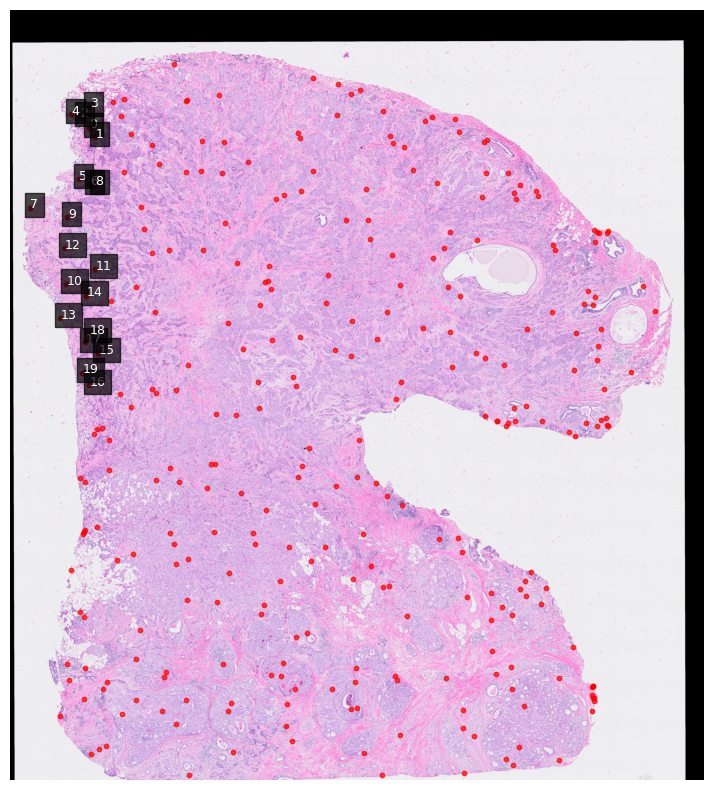

[DEBUG] Entering extract_image_patches: image shape=(53738,48376), num_points=50, P=224, kappas=[0.5, 0.75, 1.0, 1.5, 2.0]
[DEBUG] Point 0: rounded coords → (xi, yi)=(5501, 8212)
[DEBUG]  κ=0.5: crop_size=448, half=224
[DEBUG]  crop bounds for κ=0.5: x[5277:5725], y[7988:8436]
[DEBUG]  cropped shape for κ=0.5: (448, 448, 3)
[DEBUG]  resized patch shape for κ=0.5: (224, 224, 3)
[DEBUG]  κ=0.75: crop_size=299, half=149
[DEBUG]  crop bounds for κ=0.75: x[5352:5650], y[8063:8361]
[DEBUG]  cropped shape for κ=0.75: (298, 298, 3)
[DEBUG]  padding needed for κ=0.75: pad_h=1, pad_w=1, top=0, bottom=1, left=0, right=1
[DEBUG]  padded shape for κ=0.75: (299, 299, 3)
[DEBUG]  resized patch shape for κ=0.75: (224, 224, 3)
[DEBUG]  κ=1.0: crop_size=224, half=112
[DEBUG]  crop bounds for κ=1.0: x[5389:5613], y[8100:8324]
[DEBUG]  cropped shape for κ=1.0: (224, 224, 3)
[DEBUG]  resized patch shape for κ=1.0: (224, 224, 3)
[DEBUG]  κ=1.5: crop_size=150, half=75
[DEBUG]  crop bounds for κ=1.5: x[5426:5

/var/folders/c0/44p3b4xx4v956042lj_vp7z80000gn/T/ipykernel_44469/2577742161.py:513: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([byk[k] for k in [0.5,0.75,1.0,1.5,2.0]],


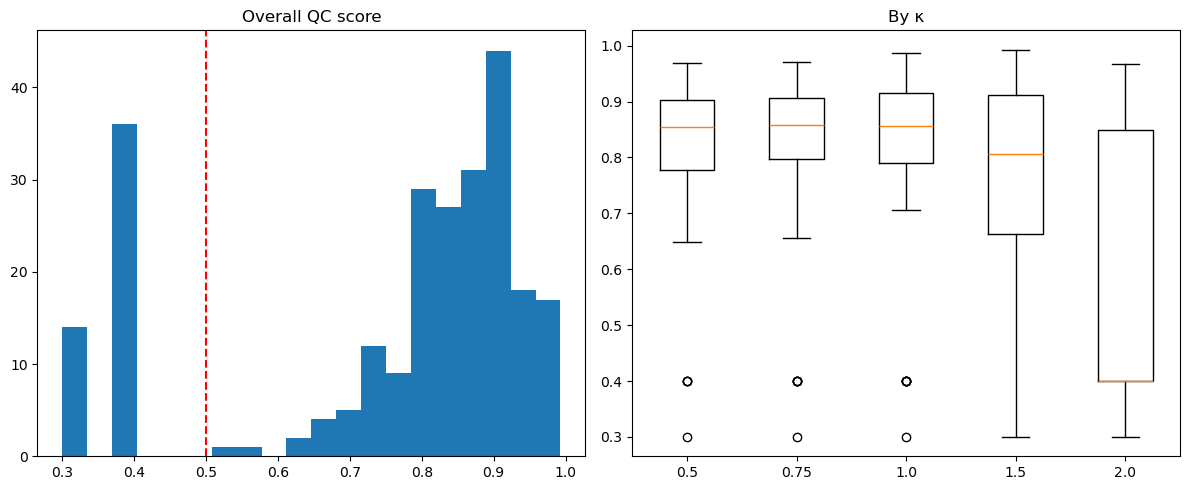

NameError: name 'compare_high_low_quality' is not defined

In [2]:
"""
COMPREHENSIVE ANNOTATION:
Cell Patch Extraction Pipeline for Xenium Spatial Transcriptomics Data

This code performs extraction and quality assessment of cell patches from H&E (Hematoxylin and Eosin) 
stained histology images, aligned with spatial transcriptomics data from the Xenium platform. 
The goal is to extract image patches centered around cell nuclei detected in Xenium data.

Key functionalities:
1. Loading spatial transcriptomics data and corresponding H&E images
2. Converting nucleus coordinates from microns to pixels
3. Sampling cells in a spatially distributed manner
4. Extracting image patches at multiple zoom levels (kappa values)
5. Evaluating the quality of extracted patches
6. Selecting the best patches based on quality metrics

The pipeline serves as a preprocessing step for downstream analysis that combines 
histological features with gene expression data at single-cell resolution.
"""

import os
import time
import random
import xml.etree.ElementTree as ET  # For parsing XML metadata in OME-TIFF files

# Numerical and data processing libraries
import numpy as np  # For efficient numerical operations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For visualization

# Image processing libraries
from scipy import ndimage  # For image transformations like distance transforms
from skimage import exposure, filters, measure, color  # For advanced image processing
from tifffile import TiffFile  # For reading TIFF files with metadata
import spatialdata as sd  # Library for spatial transcriptomics data

from tqdm.notebook import tqdm  # Progress bar for Jupyter notebooks

# =============================================================================
# Module-level cache for heavy data
# =============================================================================
# Why use module-level caching? 
# Answer: Loading large spatial datasets and high-resolution images is computationally expensive.
# Caching these objects prevents redundant loading operations, significantly improving performance
# when functions are called multiple times.
_cached_sdata = None  # Cache for SpatialData object
_cached_he_image = None  # Cache for H&E image
_cached_pixel_size = None  # Cache for pixel size (psx, psy) in microns

# Paths to data files
# Why hardcode paths?
# Answer: While not ideal for production, hardcoding simplifies development and testing.
# In a production environment, these would be parameterized or loaded from configuration.
base_dir      = "/Users/jianzhouyao/Cancer"
xenium_dir    = os.path.join(base_dir, "FFPE Human Breast with Pre-designed Panel")
zarr_path     = os.path.join(xenium_dir, "Xenium_V1_FFPE_Human_Breast_IDC_outs.zarr")
he_image_path = os.path.join(xenium_dir, "Xenium_V1_FFPE_Human_Breast_IDC_he_image.ome.tif")

# Import helper functions from external module
# Why use external helpers?
# Answer: This promotes code modularity and reusability. These functions are likely used in 
# multiple scripts or are complex enough to warrant separation for better maintainability.
from xenium_he_overlay import (
    extract_xenium_nucleus_centroids_from_spatialdata,
    extract_image_patches
)

# =============================================================================
# Data loading with caching
# =============================================================================
def load_data():
    """
    Load SpatialData and H&E image (with OME metadata) once and cache globally.
    
    Why use this function pattern?
    Answer: It implements a lazy loading pattern with caching. Data is loaded only when needed
    and stored for future use, preventing redundant loading operations.
    
    Returns:
        sdata: SpatialData object containing spatial transcriptomics data
        he_image: H&E image as ndarray (Height, Width, Channels)
        psx, psy: pixel size in microns (physical dimensions of each pixel)
    """
    global _cached_sdata, _cached_he_image, _cached_pixel_size
    
    # Load SpatialData if not already cached
    if _cached_sdata is None:
        print("→ Loading SpatialData Zarr …")
        _cached_sdata = sd.read_zarr(zarr_path)  # Load data from Zarr storage format
        print("✔ SpatialData loaded.")
    else:
        print("← Reusing cached SpatialData.")

    # Load H&E image and metadata if not already cached
    if _cached_he_image is None or _cached_pixel_size is None:
        print("→ Loading H&E TIFF (memmap) & reading OME metadata …")
        
        # Why use memmap?
        # Answer: Memory mapping allows files to be accessed without loading the entire file into
        # memory, which is crucial for large image files that might exceed available RAM.
        with TiffFile(he_image_path) as tif:
            img = tif.asarray(out='memmap')  # Load image as memory-mapped array
            ome_xml = tif.ome_metadata  # Extract OME metadata
        
        # Why check and potentially transpose the image?
        # Answer: Standardizes the image dimensions to have channels as the last dimension (H,W,C),
        # regardless of how they were stored in the TIFF file (which might be C,H,W).
        if img.ndim == 3 and img.shape[0] in (1, 3):
            img = np.moveaxis(img, 0, -1)  # Convert from (C,H,W) to (H,W,C) format
        
        # Parse OME-XML metadata to extract pixel size information
        # Why use ElementTree and namespaces?
        # Answer: OME-TIFF follows a standardized XML schema with specific namespaces.
        # Using ElementTree with appropriate namespaces ensures correct parsing.
        root = ET.fromstring(ome_xml)
        ns = {'ns': 'http://www.openmicroscopy.org/Schemas/OME/2016-06'}
        pixels = root.find('.//ns:Pixels', ns)
        
        # Extract physical pixel size in microns
        # Why default to 1.0?
        # Answer: Ensures the code doesn't fail if the metadata is missing.
        # A value of 1.0 implies 1 pixel = 1 micron as a fallback.
        psx = float(pixels.attrib.get('PhysicalSizeX', 1.0))
        psy = float(pixels.attrib.get('PhysicalSizeY', 1.0))
        
        # Store loaded data in cache
        _cached_he_image = img
        _cached_pixel_size = (psx, psy)
        
        print(f"✔ H&E loaded (shape={img.shape}), pixel sizes: X={psx} µm, Y={psy} µm")
    else:
        print("← Reusing cached H&E image and pixel sizes.")
        img = _cached_he_image
        psx, psy = _cached_pixel_size

    return _cached_sdata, img, psx, psy

# -----------------------------------------------------------------------------
# QC & preprocessing functions
# -----------------------------------------------------------------------------
def evaluate_patch_quality_improved(patch, nucleus_size_range=(200, 5000)):
    """
    Evaluate the quality of an image patch using multiple criteria.
    
    Why use multiple quality criteria?
    Answer: Cell identification requires patches with clear nuclei. Multiple criteria ensure
    comprehensive quality assessment, from basic checks (not black) to more complex analysis
    (nucleus centrality and clarity).
    
    Parameters:
        patch: Image patch to evaluate
        nucleus_size_range: Valid range for nucleus size in pixels
        
    Returns:
        is_valid: Boolean indicating if patch is valid
        score: Numerical quality score (0-1)
        reason: String explaining rejection reason or "Valid"
    """
    # Convert RGB to grayscale if needed
    # Why check dimensions?
    # Answer: Ensures the function works with both color and grayscale images.
    if patch.ndim == 3:
        gray = color.rgb2gray(patch)  # Convert RGB to grayscale
    else:
        gray = patch
    
    # Reject completely black patches
    # Why check mean intensity?
    # Answer: Black patches contain no useful information and indicate regions
    # outside the tissue or imaging artifacts.
    if np.mean(gray) < 0.05:
        return False, 0.0, "Completely black patch"
    
    # Check for sufficient intensity variation
    # Why check standard deviation?
    # Answer: Low variation indicates uniform regions without clear structures,
    # which are not informative for cell analysis.
    std_intensity = np.std(gray)
    if std_intensity < 0.05:
        return False, 0.1, "Low signal variation"
    
    # Create binary mask using Otsu thresholding
    # Why use Otsu's method?
    # Answer: It automatically determines an optimal threshold by maximizing
    # between-class variance, making it robust across different staining intensities.
    thresh = filters.threshold_otsu(gray)
    binary = gray < thresh  # Nuclei are typically darker than background
    
    # Check content ratio
    # Why check content ratio?
    # Answer: Too little content means empty patch, too much indicates
    # oversegmentation or noise. Good patches have a balanced foreground/background ratio.
    content_ratio = binary.sum() / binary.size
    if content_ratio < 0.05 or content_ratio > 0.6:
        return False, 0.2, f"Content ratio ({content_ratio:.2f}) out of range"
    
    # Calculate distance transform to identify central structures
    # Why use distance transform?
    # Answer: Distance transform converts binary image to continuous distance field,
    # useful for identifying how far points are from foreground/background boundaries.
    dist_transform = ndimage.distance_transform_edt(~binary)
    cy, cx = gray.shape[0]//2, gray.shape[1]//2  # Center coordinates
    center_region = dist_transform[cy-20:cy+20, cx-20:cx+20]
    
    # Check for structure near center
    # Why check center region specifically?
    # Answer: We want cells centered in the patch, not at edges.
    # Central structures are more likely to be complete and well-captured.
    if np.max(center_region) < 5:
        return False, 0.3, "No central structure"
    
    # Identify distinct regions (potential nuclei)
    # Why use connected component labeling?
    # Answer: It assigns unique labels to each connected region,
    # allowing individual analysis of each potential nucleus.
    labeled = measure.label(binary)
    props = measure.regionprops(labeled)
    if not props:
        return False, 0.3, "No nuclei detected"
    
    # Filter nuclei by size
    # Why filter by size?
    # Answer: Removes abnormally small artifacts and extremely large regions
    # that likely aren't single nuclei. The size range represents expected
    # nucleus sizes in pixels.
    valid = [p for p in props if nucleus_size_range[0] <= p.area <= nucleus_size_range[1]]
    if not valid:
        return False, 0.3, "No valid-sized nuclei"
    
    # Find nuclei close to the center
    # Why focus on central nuclei?
    # Answer: We want patches centered on specific cells. This ensures
    # the nucleus of interest is properly centered and captured.
    center_nucs = []
    for p in valid:
        y, x = p.centroid
        d = np.hypot(y-cy, x-cx)  # Euclidean distance from center
        if d < gray.shape[0]/4:  # Within quarter of patch dimension
            center_nucs.append((p,d))
    if not center_nucs:
        return False, 0.4, "No central nuclei"
    
    # Get the most central nucleus
    nuc, dist = min(center_nucs, key=lambda x: x[1])
    centrality = 1 - min(dist/(gray.shape[0]/2), 1.0)  # Higher value = more central
    
    # Calculate clarity (contrast between nucleus and background)
    # Why measure nucleus-background contrast?
    # Answer: High contrast indicates clear staining and good imaging conditions,
    # making the nucleus easily distinguishable from surrounding tissue.
    mask = (labeled == nuc.label)
    nuc_px = gray[mask]
    bg_px = gray[~mask]
    clarity = abs(nuc_px.mean() - bg_px.mean()) if len(nuc_px) and len(bg_px) else 0
    
    # Calculate overall quality score
    # Why use weighted criteria?
    # Answer: Different aspects have different importance. Centrality is most important,
    # followed by clarity, with content ratio being less critical but still relevant.
    score = (
        0.5 * centrality +
        0.3 * min(clarity*5, 1.0) +
        0.2 * min(content_ratio/0.3, 1.0)
    )
    return True, score, "Valid"

def normalize_patch(patch):
    """
    Normalize image patch using ImageNet mean and standard deviation.
    
    Why use ImageNet normalization?
    Answer: These values standardize images to work well with deep learning models
    pretrained on ImageNet, which is a common practice in transfer learning. It helps
    models generalize better across different image sources.
    
    Parameters:
        patch: Image patch to normalize
        
    Returns:
        norm: Normalized patch (floating point, for model input)
        vis: Visualization of normalized patch (uint8, for display)
    """
    # Convert to float32 if needed and scale to [0,1]
    pf = patch.astype(np.float32)/255.0 if patch.dtype!=np.float32 else patch.copy()
    
    # ImageNet mean and standard deviation per channel
    means = [0.485, 0.456, 0.406]  # RGB means from ImageNet
    stds  = [0.229, 0.224, 0.225]  # RGB standard deviations from ImageNet
    
    # Apply normalization: (x - mean) / std
    norm = np.zeros_like(pf)
    for i,(m,s) in enumerate(zip(means,stds)):
        norm[:,:,i] = (pf[:,:,i]-m)/s
    
    # Create visualization by reversing normalization
    # Why create visualization?
    # Answer: The normalized image values are not in displayable range.
    # This creates a version that can be visualized to verify normalization.
    vis = np.zeros_like(patch)
    for i,(m,s) in enumerate(zip(means,stds)):
        vis[:,:,i] = np.clip((norm[:,:,i]*s + m)*255, 0, 255).astype(np.uint8)
    
    return norm, vis

def extract_image_patches_enhanced(he_image, coords, P=224, kappas=[0.5,0.75,1.0,1.5,2.0]):
    """
    Extract and enhance image patches at multiple zoom levels (kappas).
    
    Why extract at multiple zoom levels?
    Answer: Different zoom levels capture different biological contexts:
    - Low kappa (high zoom): Details of individual cell
    - High kappa (low zoom): Cell's neighborhood and tissue context
    This multi-scale approach provides complementary information.
    
    Parameters:
        he_image: Full H&E image
        coords: Pixel coordinates of cell centers
        P: Patch size in pixels
        kappas: Zoom levels (smaller values = more zoomed in)
        
    Returns:
        enh: Enhanced patches (contrast-adjusted)
        normed: Normalized patches (for model input)
    """
    # Extract raw patches using external function
    raw = extract_image_patches(he_image, coords, P, kappas)
    
    enh, normed = {}, {}
    for cid in raw:
        enh[cid] = []
        normed[cid] = []
        for patch in raw[cid]:
            # Skip enhancement for black patches (likely outside image bounds)
            if patch.mean() < 5:
                enh[cid].append(patch)
                normed[cid].append(None)
            else:
                # Apply contrast enhancement using percentile-based rescaling
                # Why use 2nd and 98th percentiles?
                # Answer: This robust range excludes extreme outliers while enhancing
                # the majority of relevant image content, improving the visibility
                # of cellular structures.
                p2,p98 = np.percentile(patch, (2,98))
                ce = exposure.rescale_intensity(patch, in_range=(p2,p98))
                
                # Apply ImageNet normalization
                n, v = normalize_patch(ce)
                enh[cid].append(v)
                normed[cid].append(n)
    return enh, normed

def sample_grid_cells(centroids, grid_size=8, cells_per_grid=5):
    """
    Sample cells from a spatial grid for balanced representation.
    
    Why use grid sampling?
    Answer: Random sampling might oversample dense regions and undersample sparse ones.
    Grid sampling ensures spatial diversity across the tissue, providing a more
    representative sample of different microenvironments.
    
    Parameters:
        centroids: Array of (x,y) coordinates
        grid_size: Number of grid divisions in each dimension
        cells_per_grid: Maximum cells to sample from each grid cell
        
    Returns:
        Array of indices of sampled cells
    """
    xs, ys = centroids[:,0], centroids[:,1]
    xmin,xmax, ymin,ymax = xs.min(), xs.max(), ys.min(), ys.max()
    
    # Calculate grid cell sizes
    dx, dy = (xmax-xmin)/grid_size, (ymax-ymin)/grid_size
    
    out = []
    # Iterate through each grid cell
    for i in range(grid_size):
        for j in range(grid_size):
            # Find cells within current grid cell
            m = ((xs>=xmin+i*dx)&(xs<xmin+(i+1)*dx)&
                 (ys>=ymin+j*dy)&(ys<ymin+(j+1)*dy))
            idx = np.where(m)[0]
            
            # Sample cells from current grid cell
            if idx.size:
                take = min(cells_per_grid, idx.size)
                out.extend(np.random.choice(idx, take, replace=False))
    
    return np.array(out)

def extract_patches_with_qc(he_image, coords, P=224, kappas=[0.5,0.75,1.0,1.5,2.0]):
    """
    Extract image patches and evaluate their quality.
    
    Why combine extraction with QC?
    Answer: Processing efficiency - performs all operations in a single pass
    through the data, avoiding redundant computations and making the workflow more streamlined.
    
    Parameters:
        he_image: Full H&E image
        coords: Pixel coordinates of cell centers
        P: Patch size in pixels
        kappas: Zoom levels
        
    Returns:
        enh: Enhanced patches
        normed: Normalized patches
        qr: Quality results for each patch
    """
    # Extract and enhance patches
    enh, normed = extract_image_patches_enhanced(he_image, coords, P, kappas)
    
    # Evaluate quality of each patch
    qr = {}
    for cid in enh:
        qr[cid] = []
        for i,patch in enumerate(enh[cid]):
            ok, score, reason = evaluate_patch_quality_improved(patch)
            qr[cid].append({'kappa':kappas[i],'score':score,'is_valid':ok,'reason':reason})
    
    return enh, normed, qr

def get_best_patches(patches, qr):
    """
    Select the best patch (highest quality score) for each cell.
    
    Why select only one patch per cell?
    Answer: For downstream analysis that requires a single representative patch per cell,
    this selects the optimal zoom level that best captures the cell's features.
    
    Parameters:
        patches: Dictionary of patches per cell
        qr: Quality results
        
    Returns:
        Dictionary of best patches with quality information
    """
    best = {}
    for cid in patches:
        # Filter valid patches
        valids = [(i,q) for i,q in enumerate(qr[cid]) if q['is_valid']]
        if not valids: continue
        
        # Select patch with highest quality score
        i,q = max(valids, key=lambda x: x[1]['score'])
        best[cid] = {'patch':patches[cid][i],'kappa':q['kappa'],'score':q['score']}
    
    return best

def paper_specific_qc(patches, qr):
    """
    Apply additional quality control specific to paper requirements.
    
    Why add paper-specific QC?
    Answer: This addresses issues specific to the analysis pipeline or publication
    requirements that weren't covered by the general QC. In this case, it removes
    completely black patches at the largest zoom level.
    
    Parameters:
        patches: Dictionary of patches per cell
        qr: Quality results
        
    Returns:
        Updated patches and quality results
    """
    # Identify completely black patches at kappa=2.0
    to_rm = []
    for cid in patches:
        for i,q in enumerate(qr[cid]):
            if q['kappa']==2.0 and patches[cid][i].mean()<5:
                to_rm.append((cid,i))
    
    print(f"Removing {len(to_rm)} completely black κ=2.0 patches")
    
    # Mark identified patches as invalid
    for cid,i in to_rm:
        qr[cid][i]['is_valid']=False
        qr[cid][i]['reason']="Completely black patch"
    
    return patches, qr

def visualize_quality_distribution(qr):
    """
    Create histograms and boxplots of patch quality scores.
    
    Why visualize quality distribution?
    Answer: Visual inspection of quality scores helps identify patterns and potential issues:
    - Overall distribution shows if quality assessment is working properly
    - Per-kappa boxplots reveal which zoom levels yield better patches
    
    Parameters:
        qr: Quality results dictionary
    """
    # Collect scores overall and by kappa
    scores = []
    byk = {k:[] for k in [0.5,0.75,1.0,1.5,2.0]}
    for cid in qr:
        for q in qr[cid]:
            scores.append(q['score'])
            byk[q['kappa']].append(q['score'])
    
    # Create visualization with histogram and boxplot
    plt.figure(figsize=(12,5))
    
    # Overall score histogram
    plt.subplot(1,2,1)
    plt.hist(scores,bins=20)
    plt.axvline(0.5, color='r', linestyle='--')  # Quality threshold line
    plt.title("Overall QC score")
    
    # Boxplot by kappa value
    plt.subplot(1,2,2)
    plt.boxplot([byk[k] for k in [0.5,0.75,1.0,1.5,2.0]],
                labels=['0.5','0.75','1.0','1.5','2.0'])
    plt.title("By κ")
    
    plt.tight_layout()
    plt.show()

def create_figure_like_paper(patches, qr, n_cells=5):
    """
    Create a figure showing multiple zoom levels for top-quality cells.
    
    Why create a paper-like figure?
    Answer: Creates a standardized visualization for publication or presentation
    that demonstrates the multi-scale approach used in the analysis.
    
    Parameters:
        patches: Dictionary of patches per cell
        qr: Quality results
        n_cells: Number of cells to display
        
    Returns:
        List of selected cell IDs
    """
    # Select cells where all kappa values produced valid patches
    cells = []
    for cid in patches:
        if all(q['is_valid'] for q in qr[cid]):
            cells.append((cid, np.mean([q['score'] for q in qr[cid]])))
    
    # Sort by average quality score
    cells.sort(key=lambda x: x[1], reverse=True)
    sel = [cid for cid,_ in cells[:n_cells]]
    
    # Create visualization
    fig, axes = plt.subplots(n_cells, 5, figsize=(15,3*n_cells))
    for r,cid in enumerate(sel):
        for c in range(5):
            axes[r,c].imshow(patches[cid][c])
            axes[r,c].axis('off')
            axes[r,c].set_title(f"κ={[0.5,0.75,1.0,1.5,2.0][c]}")
    
    plt.suptitle("Top cells at all zooms")
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()
    
    return sel

def display_qc_summary(qr):
    """
    Display summary statistics of patch quality control.
    
    Why display QC summary?
    Answer: Provides a concise overview of QC results to quickly assess:
    - Overall pass rate
    - Pass rates by zoom level (kappa)
    - Which zoom level works best for this dataset
    
    Parameters:
        qr: Quality results
        
    Returns:
        best_k: Kappa value with highest pass rate
        v: Valid counts by kappa
        t: Total counts by kappa
    """
    # Count valid and total patches by kappa
    v,t = {k:0 for k in [0.5,0.75,1.0,1.5,2.0]}, {k:0 for k in [0.5,0.75,1.0,1.5,2.0]}
    for cid in qr:
        for q in qr[cid]:
            t[q['kappa']] += 1
            if q['is_valid']:
                v[q['kappa']] += 1
    
    # Display overall statistics
    print(f"Overall: {sum(v.values())}/{sum(t.values())} ({sum(v.values())/sum(t.values())*100:.1f}%)")
    
    # Display statistics by kappa
    for k in [0.5,0.75,1.0,1.5,2.0]:
        pct = v[k]/t[k]*100 if t[k] else 0
        print(f" κ={k}: {v[k]}/{t[k]} ({pct:.1f}%)")
    
    # Identify best kappa value
    best_k = max(v, key=lambda x: v[x]/(t[x] or 1))
    print(f"Best κ: {best_k}")
    
    return best_k, v, t

# =============================================================================
# Fast downsample preview via strided slicing
# =============================================================================
def create_downsampled_preview(he_image, coords_px, sample_indices, factor=10):
    """
    Create a downsampled preview of the H&E image with sampled cell locations.
    
    Why create a downsampled preview?
    Answer: Full-resolution H&E images can be extremely large (gigapixels). A downsampled
    preview allows quick visual verification of coordinate mapping and sampling without
    requiring excessive memory or computation.
    
    Parameters:
        he_image: Full H&E image
        coords_px: Pixel coordinates of all cells
        sample_indices: Indices of sampled cells
        factor: Downsampling factor
    """
    h, w = he_image.shape[:2]
    small_h, small_w = h // factor, w // factor
    print(f"→ Fast downsample to ({small_h}, {small_w}) via slicing …")
    
    # Downsample image via strided slicing
    # Why use slicing instead of interpolation?
    # Answer: Much faster for large images, and sufficient for preview purposes
    small_image = he_image[::factor, ::factor, :].astype(np.uint8)
    
    # Scale down coordinates to match downsampled image
    pts = coords_px[sample_indices] // factor
    x_pts, y_pts = pts[:, 0], pts[:, 1]
    
    # Visualize sampled points on downsampled image
    plt.figure(figsize=(8, 8))
    plt.imshow(small_image)
    plt.scatter(x_pts, y_pts, c='red', s=10, alpha=0.7)
    
    # Label first 20 points for reference
    for i, idx in enumerate(sample_indices[:20]):
        x, y = coords_px[idx] // factor
        plt.text(x + 5, y + 5, str(i), color='white', fontsize=9,
                 bbox=dict(facecolor='black', alpha=0.7))
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
# Function to compare highest and lowest quality patches
def compare_high_low_quality(patches, quality_results, n_examples=5):
    """Compare highest and lowest quality patches"""
    # Flatten quality results
    flat_results = []
    for cell_idx in quality_results:
        for i, q in enumerate(quality_results[cell_idx]):
            flat_results.append((cell_idx, i, q))
    
    # Sort by score
    flat_results.sort(key=lambda x: x[2]['score'], reverse=True)
    
    # Get top and bottom examples
    top_examples = flat_results[:n_examples]
    bottom_examples = flat_results[-n_examples:]
    
    # Create figure
    fig, axes = plt.subplots(2, n_examples, figsize=(15, 6))
    
    # Plot top examples
    for i, (cell_idx, patch_idx, q) in enumerate(top_examples):
        axes[0, i].imshow(patches[cell_idx][patch_idx])
        axes[0, i].set_title(f"Score: {q['score']:.2f}\nκ={q['kappa']}")
        axes[0, i].axis('off')
    
    # Plot bottom examples
    for i, (cell_idx, patch_idx, q) in enumerate(bottom_examples):
        axes[1, i].imshow(patches[cell_idx][patch_idx])
        axes[1, i].set_title(f"Score: {q['score']:.2f}\n{q['reason']}")
        axes[1, i].axis('off')
    
    plt.suptitle("Comparison of Highest and Lowest Quality Patches")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# =============================================================================
# Main pipeline with optional preloading
# =============================================================================
def main_patch_extraction_pipeline(sdata=None, he_image=None, psx=None, psy=None):
    """
    Main function that orchestrates the entire patch extraction pipeline.
    
    Why have a comprehensive pipeline function?
    Answer: Organizes the entire workflow in a logical sequence, making it easier to:
    1. Understand the complete process
    2. Identify bottlenecks
    3. Reuse the pipeline with different datasets
    4. Optionally skip steps by providing preloaded data
    
    Parameters:
        sdata: Optional preloaded SpatialData object
        he_image: Optional preloaded H&E image
        psx, psy: Optional preloaded pixel sizes
        
    Returns:
        Dictionary containing all extracted data and results
    """
    t_start = time.time()
    print("[DEBUG] Starting patch extraction pipeline\n")
    
    # Load data if not provided
    if sdata is None or he_image is None or psx is None or psy is None:
        sdata, he_image, psx, psy = load_data()
    else:
        print("← Using provided SpatialData and H&E image, skipping load_data.")
    
    # Extract nucleus centroids from spatial data
    print("→ Extracting Xenium nucleus centroids (µm) …")
    centroids_um, cell_ids = extract_xenium_nucleus_centroids_from_spatialdata(sdata)
    print(f"✔ Retrieved {len(centroids_um)} centroids (µm)\n")
    
    # Convert physical coordinates (microns) to pixel coordinates
    print("→ Converting centroids from µm → pixels …")
    coords_px = np.zeros_like(centroids_um, dtype=int)
    coords_px[:, 0] = np.round(centroids_um[:, 0] / psx).astype(int)
    coords_px[:, 1] = np.round(centroids_um[:, 1] / psy).astype(int)
    print("✔ Sample pixel coords:", coords_px[:5], "\n")
    
    # Clip coordinates to image boundaries
    # Why clip coordinates?
    # Answer: Prevents out-of-bounds errors when extracting patches.
    # Some cells might be detected slightly outside the imaged area.
    h, w = he_image.shape[:2]
    coords_px[:, 0] = np.clip(coords_px[:, 0], 0, w - 1)
    coords_px[:, 1] = np.clip(coords_px[:, 1], 0, h - 1)
    
    # Sample cells using grid-based approach
    # Why sample instead of using all cells?
    # Answer: Processing all cells would be computationally expensive and unnecessary
    # for quality assessment or method development. Grid sampling ensures spatial
    # diversity while keeping the sample size manageable.
    sample_idx = sample_grid_cells(coords_px, grid_size=8, cells_per_grid=5)
    print(f"→ Sampled {len(sample_idx)} cells\n")
    
    # Create visual preview of sampled cells
    create_downsampled_preview(he_image, coords_px, sample_idx)
    
    # Extract patches only for sampled cells and assess quality
    # Why limit to 50 cells for testing?
    # Answer: Initial testing with a smaller subset allows for quick iteration
    # and debugging before scaling to the full dataset.
    test_idxs = sample_idx[:min(50, len(sample_idx))]
    enhanced_patches, normalized_patches, quality_results = \
        extract_patches_with_qc(he_image, coords_px[test_idxs])
    print(f"✔ Extracted patches for {len(enhanced_patches)} cells\n")
    
    # Apply additional quality control specific to the analysis
    # Why have a separate paper-specific QC step?
    # Answer: Keeps the general-purpose QC functions reusable across projects
    # while allowing customization for specific use cases.
    final_patches, final_quality = paper_specific_qc(enhanced_patches, quality_results)
    display_qc_summary(final_quality)
    
    # Visualize quality metrics distribution
    visualize_quality_distribution(final_quality)
    
    # This function is referenced but missing implementation
    # Likely compares high vs low quality patches for educational purposes
    compare_high_low_quality(final_patches, final_quality)
    
    # Create multi-scale visualization for paper figure
    create_figure_like_paper(final_patches, final_quality)
    
    # Get best patch for each cell based on quality metrics
    # Why select the best patch?
    # Answer: For downstream analysis or model training, we often want a single
    # representative patch per cell at the optimal zoom level.
    best_patches = get_best_patches(final_patches, final_quality)
    print(f"✔ {len(best_patches)} high-quality patches\n")
    
    # Display selection of best patches
    n_display = min(10, len(best_patches))
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    for i, (cid, info) in enumerate(list(best_patches.items())[:n_display]):
        axes[i].imshow(info['patch'])
        axes[i].axis('off')
        axes[i].set_title(f"Cell {cid}\nκ={info['kappa']}, {info['score']:.2f}")
    plt.tight_layout()
    plt.show()
    
    # Calculate and display total processing time
    print(f"\nTotal processing time: {time.time() - t_start:.1f}s")
    
    # Return all extracted data for potential downstream use
    # Why return a comprehensive dictionary?
    # Answer: Allows flexibility for different downstream analyses,
    # debugging, or further processing without rerunning the entire pipeline.
    return {
        'centroids_px': coords_px,
        'cell_ids': cell_ids,
        'sample_indices': sample_idx,
        'enhanced_patches': final_patches,
        'normalized_patches': normalized_patches,
        'quality_results': final_quality,
        'best_patches': best_patches
    }

if __name__ == '__main__':
    # Optionally preload data once
    sdata_cache, he_image_cache, psx_cache, psy_cache = load_data()
    # Then reuse caches on subsequent calls
    results = main_patch_extraction_pipeline(
        sdata=sdata_cache,
        he_image=he_image_cache,
        psx=psx_cache,
        psy=psy_cache
    )